In [77]:
from atm_data.data_utils.weather_noaa_data import *
from pathlib import Path
from ast import literal_eval
import pandas as pd
import numpy as np
import functools

import matplotlib.pyplot as plt
# plt.rcParams['figure.dpi'] = 100
%matplotlib ipympl

from matplotlib import cm, colors
from scipy.stats import gaussian_kde as kde

from scipy.stats import pearsonr

plt.rcParams['font.size'] = 8
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 300

dir_path = Path.cwd()


In [78]:
data_dir = Path.cwd().resolve().parent / 'data'
weather_path = data_dir / 'noaa_lcdv2/lcd_lga_1987-2023_cleaned.parquet'
# TODO: handling in the bayesair remapped to like not have to do the "_decade" suffix
schedule_path = data_dir / 'bts_remapped/lga_reduced_2010-2019_clean_decade/parquet/lga_reduced_2010-2019_clean_decade.parquet'

# start_date = "2019-07-01"
# end_date = "2019-08-01" # exclusive

start_date = "2010-01-01"
end_date = "2020-01-01" # exclusive

wdf = pd.read_parquet(weather_path)
sdf = pd.read_parquet(schedule_path)
sdf = (
    sdf.set_index(
        pd.DatetimeIndex(sdf['date'])
    )
    .drop(['date'], axis=1)
)


wdf = wdf.loc[(wdf.index >= start_date) & (wdf.index < end_date)]
sdf = sdf.loc[(sdf.index >= start_date) & (sdf.index < end_date)]

# mask = (sdf.scheduled_departure_time == sdf.scheduled_arrival_time)
# display(sdf.loc[mask])

for df in (wdf, sdf):
    display(df)
    display(df.dtypes)


,hourly_alitmeter_setting,hourly_dew_point_temperature,hourly_dry_bulb_temperature,hourly_precipitation,hourly_relative_humidity,hourly_visibility,hourly_wind_direction,hourly_wind_speed,hourly_wind_gust_speed,hpwt_BCFG,...,hsc_layer_1_height,hsc_layer_2_height,hsc_layer_3_height,hsc_total_coverage,hsc_total_amount,hsc_total_height,hsc_ceiling_coverage,hsc_ceiling_amount,hsc_ceiling_height,hourly_sky_conditions
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,1015.2,-0.6,0.6,0.3,92.0,4.023,60.0,1.5,0.0,False,...,1.52,4.27,NaN,OVC,8.0,4.27,OVC,8.0,4.27,SCT:04-1.52 OVC:08-4.27
2010-01-01 01:00:00,1015.2,0.0,1.1,0.0,92.0,4.023,60.0,0.0,0.0,False,...,1.83,4.27,NaN,OVC,8.0,4.27,BKN,7.0,1.83,BKN:07-1.83 OVC:08-4.27
2010-01-01 02:00:00,1014.9,0.0,1.1,0.0,92.0,4.828,80.0,1.5,0.0,False,...,1.83,NaN,NaN,OVC,8.0,1.83,OVC,8.0,1.83,OVC:08-1.83
2010-01-01 03:00:00,1014.6,0.0,0.6,0.0,96.0,8.047,90.0,0.0,0.0,False,...,1.83,NaN,NaN,OVC,8.0,1.83,OVC,8.0,1.83,OVC:08-1.83
2010-01-01 04:00:00,1014.2,0.0,0.6,0.0,96.0,8.047,100.0,1.5,0.0,False,...,1.83,NaN,NaN,OVC,8.0,1.83,OVC,8.0,1.83,OVC:08-1.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,1003.0,1.7,7.2,0.0,68.0,16.093,210.0,4.6,0.0,False,...,15.24,18.29,NaN,OVC,8.0,18.29,BKN,7.0,15.24,BKN:07-15.24 OVC:08-18.29
2019-12-31 20:00:00,1004.1,1.1,6.7,0.3,68.0,16.093,280.0,7.2,12.4,False,...,8.23,10.06,14.94,OVC,8.0,14.94,OVC,8.0,14.94,FEW:02-8.23 SCT:04-10.06 OVC:08-14.94
2019-12-31 21:00:00,1003.7,0.0,6.1,0.0,65.0,16.093,270.0,6.2,10.8,False,...,8.23,16.76,NaN,OVC,8.0,16.76,OVC,8.0,16.76,FEW:02-8.23 OVC:08-16.76


hourly_alitmeter_setting         float64
hourly_dew_point_temperature     float64
hourly_dry_bulb_temperature      float64
hourly_precipitation             float64
hourly_relative_humidity         float64
hourly_visibility                float64
hourly_wind_direction            float64
hourly_wind_speed                float64
hourly_wind_gust_speed           float64
hpwt_BCFG                        boolean
hpwt_BL                          boolean
hpwt_BLSN                        boolean
hpwt_BR                          boolean
hpwt_DRSN                        boolean
hpwt_DZ                          boolean
hpwt_FG                          boolean
hpwt_FU                          boolean
hpwt_FZDZ                        boolean
hpwt_FZFG                        boolean
hpwt_FZRA                        boolean
hpwt_GR                          boolean
hpwt_GS                          boolean
hpwt_HAIL                        boolean
hpwt_HZ                          boolean
hpwt_MIFG       

,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure_time,scheduled_arrival_time,actual_departure_time,actual_arrival_time,wheels_off_time,wheels_on_time,...,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,cancelled,cancellation_code,diverted,diverted_reached_destination,diverted_airport_landings
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,AA:705,N4XPAA,LGA,DFW,6.000000,10.083333,5.916667,9.833333,6.183333,9.750000,...,0.00,0.0,0.000000,0.0,0.0,False,Z,False,<NA>,0
2010-01-01,AA:2257,N5DCAA,LGA,MIA,6.000000,9.166667,6.100000,9.433333,6.533333,9.316667,...,0.00,0.1,0.166667,0.0,0.0,False,Z,False,<NA>,0
2010-01-01,B6:371,N661JB,LGA,FLL,6.000000,8.950000,6.050000,9.650000,6.766667,9.566667,...,0.05,0.0,0.650000,0.0,0.0,False,Z,False,<NA>,0
2010-01-01,DL:1769,N676DL,LGA,ATL,6.000000,8.733333,6.000000,8.616667,6.283333,8.466667,...,0.00,0.0,0.000000,0.0,0.0,False,Z,False,<NA>,0
2010-01-01,FL:359,N338AT,LGA,ATL,6.000000,8.600000,5.950000,8.900000,6.433333,8.750000,...,0.00,0.0,0.300000,0.0,0.0,False,Z,False,<NA>,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31,B6:1332,N328JB,LGA,BOS,21.500000,22.683333,21.200000,22.250000,21.400000,22.100000,...,0.00,0.0,0.000000,0.0,0.0,False,Z,False,<NA>,0
2019-12-31,DL:2814,N321DH,ATL,LGA,21.500000,23.633333,21.466667,23.350000,21.650000,23.233333,...,0.00,0.0,0.000000,0.0,0.0,False,Z,False,<NA>,0
2019-12-31,B6:1431,N198JB,BOS,LGA,21.500000,22.783333,21.616667,22.516667,21.850000,22.483333,...,0.00,0.0,0.000000,0.0,0.0,False,Z,False,<NA>,0


flight_number                   string[python]
tail_number                     string[python]
origin_airport                  string[python]
destination_airport             string[python]
scheduled_departure_time               float64
scheduled_arrival_time                 float64
actual_departure_time                  float64
actual_arrival_time                    float64
wheels_off_time                        float64
wheels_on_time                         float64
departure_delay                        float64
arrival_delay                          float64
carrier_delay                          float64
weather_delay                          float64
nas_delay                              float64
security_delay                         float64
late_aircraft_delay                    float64
cancelled                              boolean
cancellation_code                     category
diverted                               boolean
diverted_reached_destination           boolean
diverted_airp

In [79]:
# TODO: some stats
# mask = (sdf.origin_airport == 'LGA')
# mask = (sdf.destination_airport == 'LGA')
# mask = (sdf.scheduled_departure_time == sdf.scheduled_arrival_time)
# display(sdf.loc[mask, ["scheduled_departure_time", "scheduled_arrival_time"]])
# display(sdf.loc[mask])
# uhh ok i guess it wasn't an sisue

sdf['scheduled_event_time'] = sdf.scheduled_departure_time.copy()
mask = sdf.destination_airport == 'LGA'
sdf.loc[mask, "scheduled_event_time"] = sdf.loc[mask, "scheduled_arrival_time"]

sdf['actual_event_time'] = sdf.actual_departure_time.copy()
mask = sdf.destination_airport == 'LGA'
sdf.loc[mask, "actual_event_time"] = sdf.loc[mask, "actual_arrival_time"]

sdf['scheduled_event_datetime'] = sdf.index + pd.to_timedelta(sdf.scheduled_event_time, unit='H')
sdf['actual_event_datetime'] = sdf.index + pd.to_timedelta(sdf.actual_event_time, unit='H')

sdf['event_delay'] = sdf.actual_event_time - sdf.scheduled_event_time
sdf.loc[sdf.cancelled | sdf.diverted, 'event_delay'] = 0.0

sdf['event_delay_relu'] = sdf.event_delay.clip(lower=0.0)
sdf['arrival_delay_relu'] = sdf.arrival_delay.clip(lower=0.0)
sdf['departure_delay_relu'] = sdf.departure_delay.clip(lower=0.0)

display(sdf)

,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure_time,scheduled_arrival_time,actual_departure_time,actual_arrival_time,wheels_off_time,wheels_on_time,...,diverted_reached_destination,diverted_airport_landings,scheduled_event_time,actual_event_time,scheduled_event_datetime,actual_event_datetime,event_delay,event_delay_relu,arrival_delay_relu,departure_delay_relu
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,AA:705,N4XPAA,LGA,DFW,6.000000,10.083333,5.916667,9.833333,6.183333,9.750000,...,<NA>,0,6.000000,5.916667,2010-01-01 06:00:00.000000000,2010-01-01 05:55:00.000000001,-0.083333,0.00,0.000000,0.000000
2010-01-01,AA:2257,N5DCAA,LGA,MIA,6.000000,9.166667,6.100000,9.433333,6.533333,9.316667,...,<NA>,0,6.000000,6.100000,2010-01-01 06:00:00.000000000,2010-01-01 06:06:00.000000000,0.100000,0.10,0.266667,0.100000
2010-01-01,B6:371,N661JB,LGA,FLL,6.000000,8.950000,6.050000,9.650000,6.766667,9.566667,...,<NA>,0,6.000000,6.050000,2010-01-01 06:00:00.000000000,2010-01-01 06:03:00.000000000,0.050000,0.05,0.700000,0.050000
2010-01-01,DL:1769,N676DL,LGA,ATL,6.000000,8.733333,6.000000,8.616667,6.283333,8.466667,...,<NA>,0,6.000000,6.000000,2010-01-01 06:00:00.000000000,2010-01-01 06:00:00.000000000,0.000000,0.00,0.000000,0.000000
2010-01-01,FL:359,N338AT,LGA,ATL,6.000000,8.600000,5.950000,8.900000,6.433333,8.750000,...,<NA>,0,6.000000,5.950000,2010-01-01 06:00:00.000000000,2010-01-01 05:57:00.000000000,-0.050000,0.00,0.300000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31,B6:1332,N328JB,LGA,BOS,21.500000,22.683333,21.200000,22.250000,21.400000,22.100000,...,<NA>,0,21.500000,21.200000,2019-12-31 21:30:00.000000000,2019-12-31 21:12:00.000000000,-0.300000,0.00,0.000000,0.000000
2019-12-31,DL:2814,N321DH,ATL,LGA,21.500000,23.633333,21.466667,23.350000,21.650000,23.233333,...,<NA>,0,23.633333,23.350000,2019-12-31 23:37:59.999999998,2019-12-31 23:21:00.000000000,-0.283333,0.00,0.000000,0.000000
2019-12-31,B6:1431,N198JB,BOS,LGA,21.500000,22.783333,21.616667,22.516667,21.850000,22.483333,...,<NA>,0,22.783333,22.516667,2019-12-31 22:46:59.999999998,2019-12-31 22:31:00.000000001,-0.266667,0.00,0.000000,0.116667


In [80]:
def plot_condition_and_delays(
    type, 
    # these should be aligned time-wise
    conditions,
    dep_delays,
    arr_delays,
    start,
    end,
    condition_aggregation,
    delay_aggregation,
    colors = ('blue', 'red', 'orange'),
    figsize = (8,8)
):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()

    ax.plot(conditions, color=colors[0], label=f'{type}')
    ax2.plot(dep_delays, color=colors[1], label='departure delay')
    ax2.plot(arr_delays, color=colors[2], label='arrival delay')

    add_decorations(fig, ax, ax2, type, condition_aggregation, delay_aggregation, start, end, 'horizontal')

    return fig


def scatter_condition_and_delays(
    type, 
    # these should be aligned time-wise
    conditions,
    dep_delays,
    arr_delays,
    start,
    end,
    condition_aggregation,
    delay_aggregation,
    colors = ('blue', 'red', 'orange'),
    figsize = (8,8)
):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    def rand_jitter(arr, k=.01):
        stdev = (.01 if k is None else k) * (max(arr) - min(arr))
        return arr + np.random.randn(len(arr)) * stdev

    def jitter(ax, x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, hold=None, k=None, **kwargs):
        return ax.scatter(rand_jitter(x, k), rand_jitter(y, k), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, **kwargs)

    def plot_scatter_and_trend(ax, x, y, color, linestyle='-', marker='.', label=None, d=1):        
        # ax.scatter(x, y, color=c, marker=marker, label=label)
        jitter(ax, x, y, c=c, marker=marker, label=label, k=.03)
        z = np.polyfit(x, y, deg=d)
        p = np.poly1d(z)
        plt.plot(x, p(x), color=color, linestyle=linestyle)

    x = conditions
    for y, c, l in ((dep_delays, colors[1], 'departure'), (arr_delays, colors[2], 'arrival')):
        r, _ = pearsonr(x, y)
        plot_scatter_and_trend(ax, x.to_numpy(), y.to_numpy(), c, label=f'{l}, ρ={r:.03f}')

    add_decorations(fig, ax, None, type, condition_aggregation, delay_aggregation, start, end, 'vertical')

    return fig


def add_decorations(
    fig, ax, ax2, type, condition_aggregation, delay_aggregation, start, end, side
):
    if side == 'horizontal':
        set_condition_label = ax.set_ylabel
        set_delay_label = ax2.set_ylabel
        ax.set_ylim(bottom=0)
        add_flight_rule_regions(ax, type, 'horizontal')
        ax.set_xlabel('date')
        fig.legend(fontsize=6)
    elif side == 'vertical':
        set_condition_label = ax.set_xlabel
        set_delay_label = ax.set_ylabel
        ax.set_xlim(left=0)
        add_flight_rule_regions(ax, type, 'vertical')
        ax.legend(fontsize=6)
    else:
        raise ValueError

    set_condition_label(
        f"{type} {condition_aggregation} {'(feet)' if type == 'Ceiling' else '(miles)'}"
    )
    set_delay_label(f'Delay {delay_aggregation} (hours)')

    # ax.set_title(
    #     f'{type} and delays between {start} and {end}'
    # )


def add_flight_rule_regions(
    ax, 
    type,
    side, 
    thresholds=None,
    colors=None,
    alpha=.2,
    linestyle='--',
):
    if side == 'horizontal':
        add_line = ax.axhline
        add_span = ax.axhspan
        cmin, cmax = ax.get_ylim()            
    elif side == 'vertical':
        add_line = ax.axvline
        add_span = ax.axvspan
        cmin, cmax = ax.get_xlim()
    else:
        raise ValueError('type must be horizontal or vertical :(')

    if thresholds is None:
        if type == 'Ceiling':
            thresholds = [500, 1000, 3200]
        elif type == 'Visibility':
            thresholds = [1, 3, 4]
        else:
            raise ValueError('type must be ceiling or visibility')
    else:
        assert len(thresholds) == 3 # TODO: generalize??
        
    if colors is None:
        colors = ['darkred', 'red', 'yellow', 'lightgreen']
    else:
        assert len(colors) == 4 # TODO: generalize??

    for threshold, color in zip(thresholds, colors):
        add_line(threshold, color=color, linestyle=linestyle)
    
    span_lo = [cmin] + thresholds
    span_hi = thresholds + [cmax]

    labels = [
        'LIFR (low IFR)',
        'IFR (instrument)',
        'MVFR (marginal)',
        'VFR (visual)',
    ]
    
    for lo, hi, color, label in zip(span_lo, span_hi, colors, labels):
        add_span(lo, hi, facecolor=color, alpha=alpha, label=label)



In [81]:
# TODO: maybe we can auto-generate a description??
def process_series(
    s,
    *argv,
):
    # print(argv)
    for arg in argv:
        # print(arg, type(arg))
        if isinstance(arg, str):
            action = arg
            if action == 'no_inf':
                s = s.loc[~s.isin([np.inf])]
            elif action == 'no_nan':
                s = s.loc[~s.isin([np.nan])]
            elif action == 'inverse':
                s = 1.0 / s
        elif isinstance(arg, (list, tuple, np.ndarray)):
            action = arg[0]
            if action == 'scale':
                s = s * arg[1]
            elif action == 'clip':
                s = s.clip(lower=arg[1], upper=arg[2])
            elif action == 'filter_index':
                s = s.loc[(arg[1] <= s.index) & (s.index < arg[2])]
            elif action == 'apply_func':
                s = s.apply(arg[1])
            elif action == 'apply_func_vec':
                s = arg[1](s)
            else:
                sg = s.groupby(pd.Grouper(freq=arg[1]))
                if action == 'mean':
                    s = sg.mean()
                elif action == 'min':
                    s = sg.min()
                elif action == 'max':
                    s = sg.max()
                elif action == 'size':
                    s = sg.size()
                else:
                    raise ValueError(f'invalid step: {arg}')
    return s

freq = '1D'
ceiling = wdf.hsc_ceiling_height

process_ceiling = functools.partial(process_series, ceiling)

ch_daily_finite_mean = process_ceiling(
    'no_inf', 'no_nan', ('mean', freq)
)

ch_daily_min = process_ceiling(
    'min'
)

ch_daily_inverse_mean = process_ceiling(
    'inverse', ('mean', freq)
)
ch_daily_harmonic_mean = process_series(
    ch_daily_inverse_mean, 'inverse'
)

ch_hourly_clipped = process_ceiling(
    ('clip', .5, 64)
)

ch_daily_clipped_mean = process_series(
    ch_hourly_clipped, ('mean', freq)
)

ch_daily_clipped_inverse_mean = process_series(
    ch_hourly_clipped, ('inverse'), ('mean', freq)  
)

ch_daily_clipped_harmonic_mean = process_series(
    ch_daily_clipped_inverse_mean, ('inverse')
)

# display(ch_daily_clipped_harmonic_mean.nsmallest(5))

sdf_outgoing = sdf.loc[sdf.origin_airport == 'LGA']
sdf_incoming = sdf.loc[sdf.destination_airport == 'LGA']

dep_delay_daily = process_series(
    sdf_outgoing.departure_delay_relu, ('mean', freq)
)
arr_delay_daily = process_series(
    sdf_incoming.arrival_delay_relu, ('mean', freq)
)


In [90]:
# show that we can do these from scratch easily!
# though maybe kinda silly and not much benefit over pandas methods
freq = '1D'
start = '2019-07-01'
end = '2019-08-01'

processed_ceiling = process_series(
    wdf.hsc_ceiling_height,
    ('filter_index', start, end),
    ('clip', .5, 64), 
    ('scale', 100), 
    ('inverse'), 
    ('mean', freq), 
    ('inverse'),
)
v = processed_ceiling

d = process_series(
    sdf_outgoing.departure_delay_relu,
    ('filter_index', start, end),
    ('mean', freq),
)

a = process_series(
    sdf_incoming.arrival_delay_relu,
    ('filter_index', start, end),
    ('mean', freq),
)

In [83]:
# fig = plot_condition_and_delays(
#     type='ceiling', 
#     conditions=v,
#     dep_delays=d,
#     arr_delays=a,
#     start=start,
#     end=end,
#     condition_aggregation='daily clipped harmonic mean',
#     delay_aggregation='daily mean',
#     figsize=(3.5,1.5)
# )

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


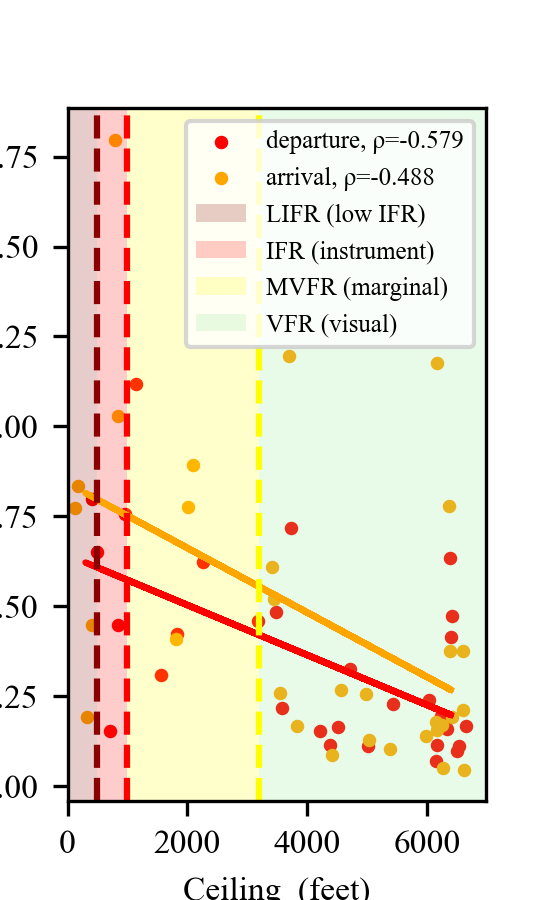

In [91]:
fig = scatter_condition_and_delays(
    type='Ceiling', 
    conditions=v,
    dep_delays=d,
    arr_delays=a,
    start=start,
    end=end,
    # condition_aggregation='daily clipped harmonic mean',
    # delay_aggregation='daily mean',
    condition_aggregation='',
    delay_aggregation='',
    figsize=(1.8,3.0)
)

for ext in ('png', 'eps', 'pdf'):
    plt.savefig(f'paper_plots/ceiling_delays_scatter2d.{ext}', bbox_inches='tight', pad_inches=0.01)

In [92]:
processed_visibility = process_series(
    wdf.hourly_visibility,
    ('filter_index', start, end),
    ('clip', .001, 10), 
    # ('inverse'), 
    # ('mean', freq), 
    # ('inverse'),
    ('min', freq)
)

v = processed_visibility

# fig = plot_condition_and_delays(
#     type='visibility', 
#     conditions=v,
#     dep_delays=d,
#     arr_delays=a,
#     start=start,
#     end=end,
#     condition_aggregation='daily min',
#     delay_aggregation='daily mean',
#     figsize=(3.5,3.5)
# )

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


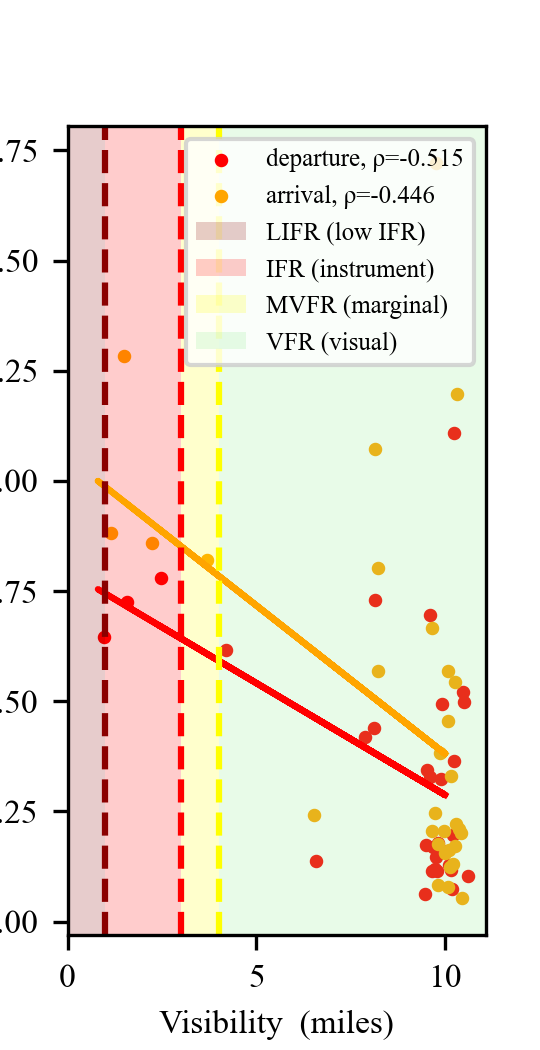

In [94]:
fig = scatter_condition_and_delays(
    type='Visibility', 
    conditions=v,
    dep_delays=d,
    arr_delays=a,
    start=start,
    end=end,
    # condition_aggregation='daily minimum',
    # delay_aggregation='daily mean',
    condition_aggregation='',
    delay_aggregation='',
    figsize=(1.8, 3.0)
)

for ext in ('png', 'eps', 'pdf'):
    plt.savefig(f'paper_plots/visibility_delays_scatter2d.{ext}', bbox_inches='tight', pad_inches=0.01)

In [126]:
freq = '1D'
start = '2018-01-01'
end = '2020-01-01'

processed_ceiling = process_series(
    wdf.hsc_ceiling_height,
    ('filter_index', start, end),
    ('clip', .1, 100), 
    ('scale', 100), 
    ('inverse'), 
    ('mean', freq), 
    ('inverse'),
)

processed_visibility = process_series(
    wdf.hourly_visibility,
    ('filter_index', start, end),
    ('clip', .001, 10), 
    # ('inverse'), 
    # ('mean', freq), 
    # ('inverse'),
    ('min', freq)
)

d = process_series(
    sdf_outgoing.departure_delay_relu,
    ('filter_index', start, end),
    ('mean', freq),
)

a = process_series(
    sdf_incoming.arrival_delay_relu,
    ('filter_index', start, end),
    ('mean', freq),
)

processed_delay = process_series(
    sdf.event_delay_relu,
    ('filter_index', start, end),
    ('mean', freq),
)

samples = np.array([processed_ceiling, processed_visibility])

print(samples)

def scatter_test(processed_ceiling, processed_visibility, a, k=.04, figsize=(8,8)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    a = a.to_numpy()

    # define color map
    cmap = plt.colormaps["Spectral_r"]
    # c = kde(samples).evaluate(samples)
    c = a * 60 #* kde(samples).evaluate(samples)

    norm = colors.Normalize(min(c), max(c))

    def rand_jitter(arr, k=.01):
        stdev = (.01 if k is None else k) * (max(arr) - min(arr))
        return arr + np.random.randn(len(arr)) * stdev

    def jitter(ax, x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, hold=None, k=None, **kwargs):
        return ax.scatter(rand_jitter(x, k), rand_jitter(y, k), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, **kwargs)

    cn = ((c-min(c))/(max(c)-min(c)))
    cns = 45*(cn**2)+5
    cna = .6*cn+.2
    jitter(ax, processed_ceiling, processed_visibility, c=c, cmap=cmap, alpha=cna, s=cns, k=k)

    # ax.set_xlim(-80, 4000)
    # ax.set_ylim(-.1, 5)
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    cbar.set_label('Delay (minutes)')

    ax.set_xlabel('Ceiling (feet)')
    ax.set_ylabel('Visibility (miles)')

    return fig

[[1.00000000e+04 9.38905432e+03 6.51949819e+03 ... 5.83897070e+02
  2.08502590e+02 5.78082800e+02]
 [1.00000000e+01 1.00000000e+01 1.00000000e+01 ... 2.41400000e+00
  2.41400000e+00 1.00000000e+01]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


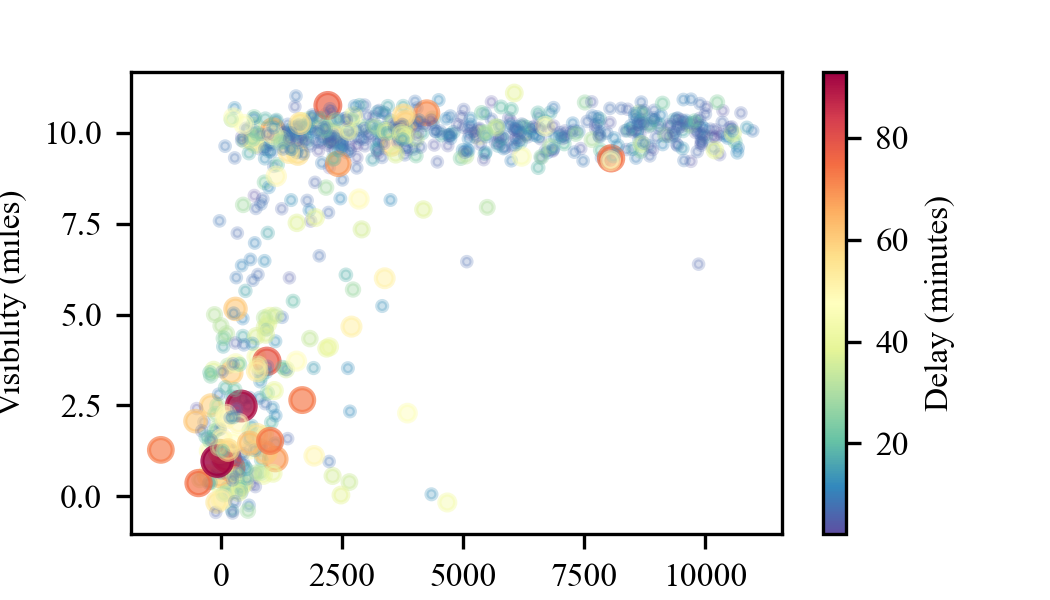

In [128]:
fig = scatter_test(processed_ceiling, processed_visibility, processed_delay, figsize=(3.5,2.0))

for ext in ('png', 'eps', 'pdf'):
    plt.savefig(f'paper_plots/visibility_delays_bubble2d.{ext}', bbox_inches='tight', pad_inches=0.01)

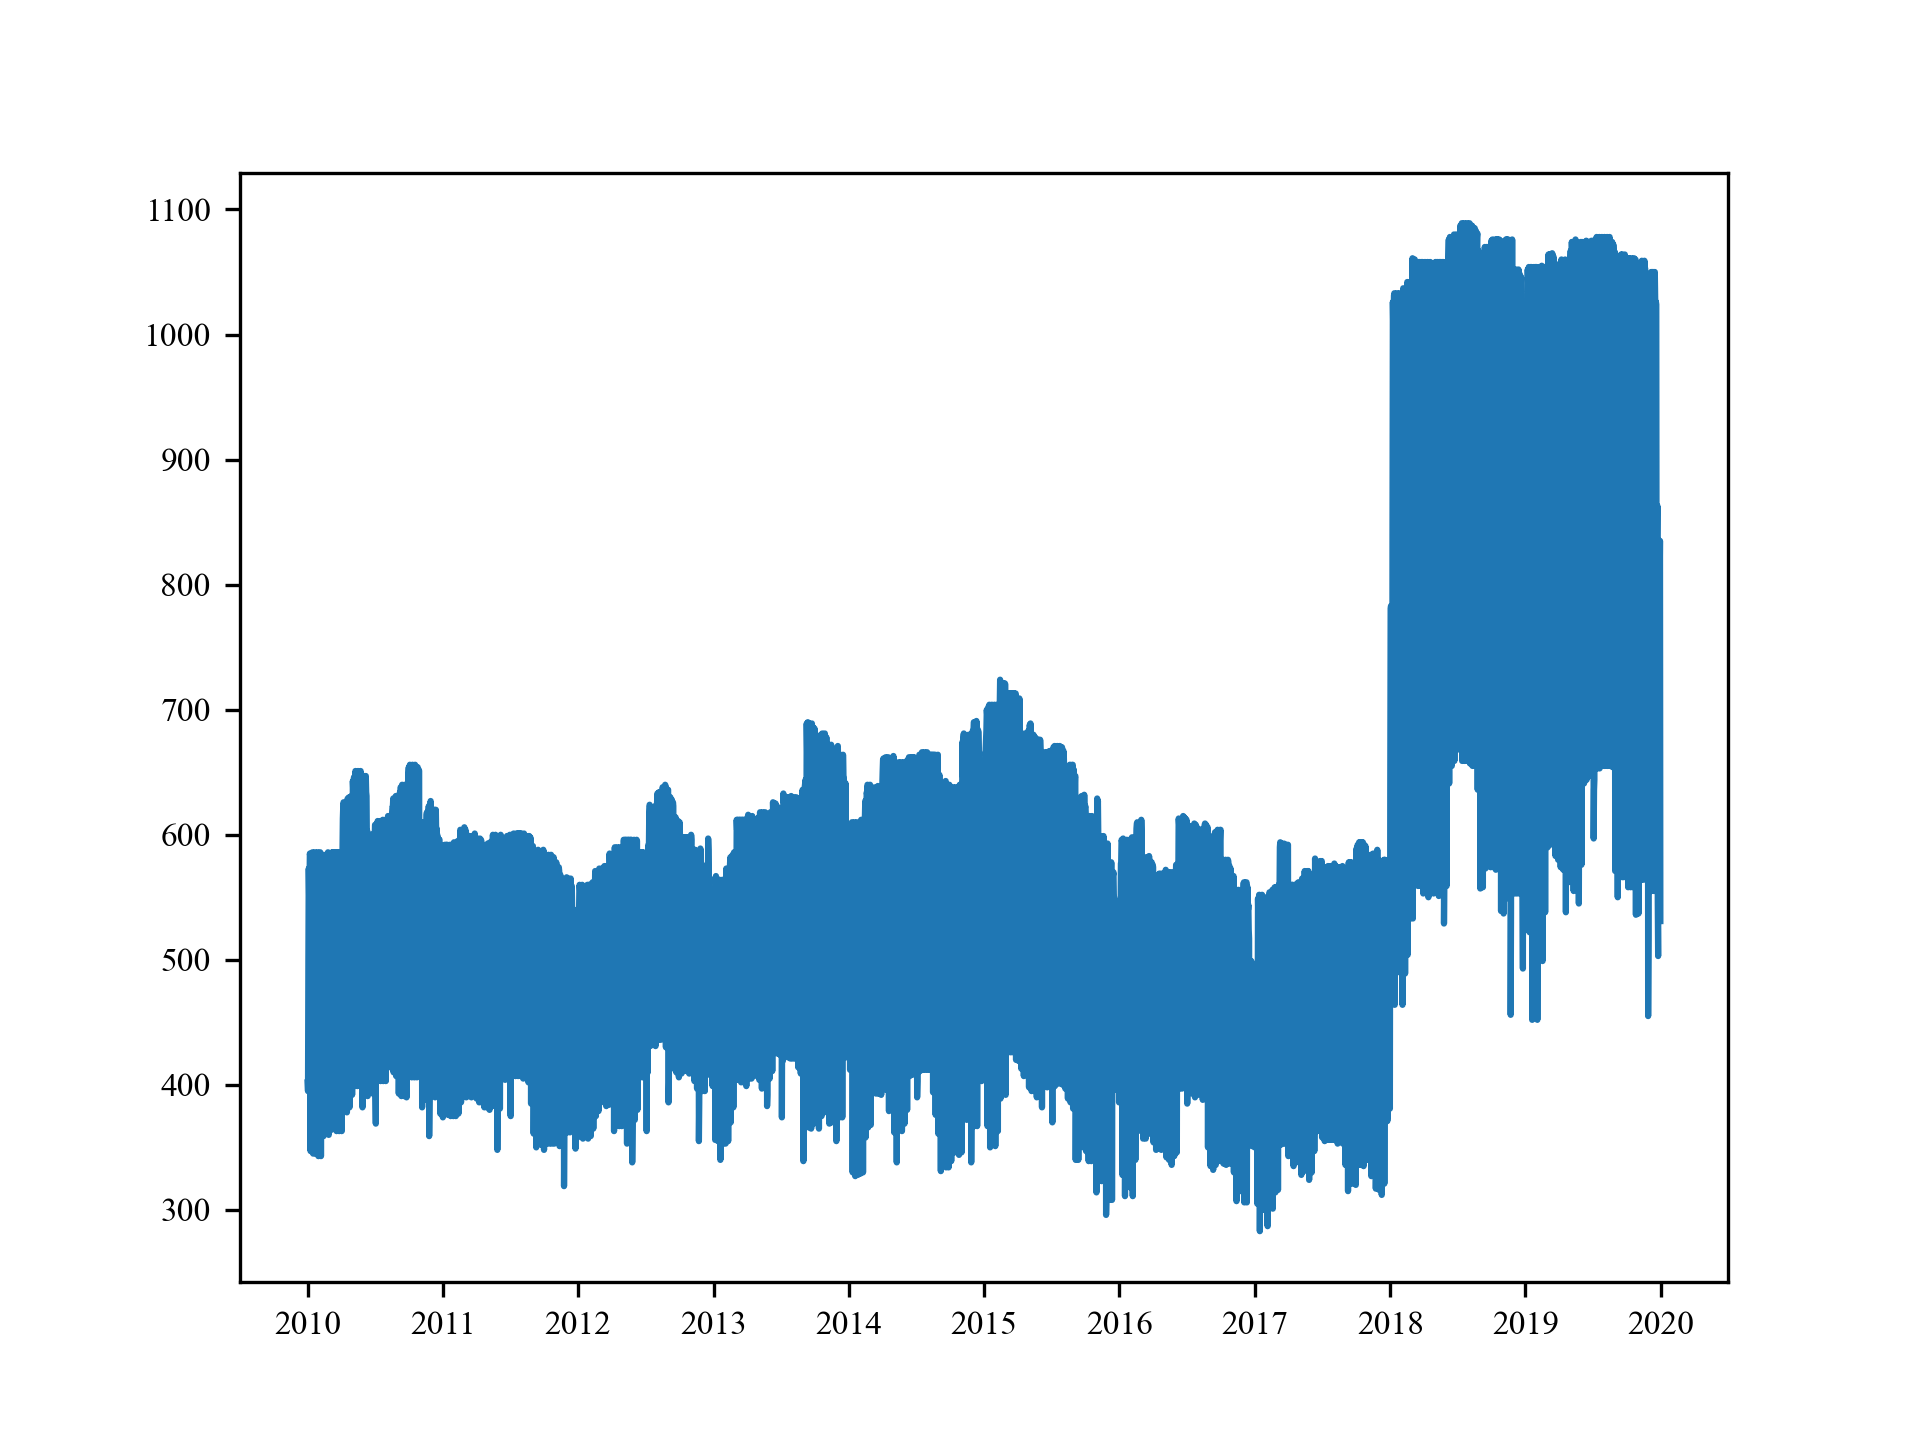

In [129]:
freq = '1D'
start = '2010-01-01'
end = '2020-01-01'

flight_counts = process_series(
    sdf.flight_number,
    ('size', freq)
)

plt.figure()
plt.plot(flight_counts)

Text(0.5, 1.0, 'daily flight counts')

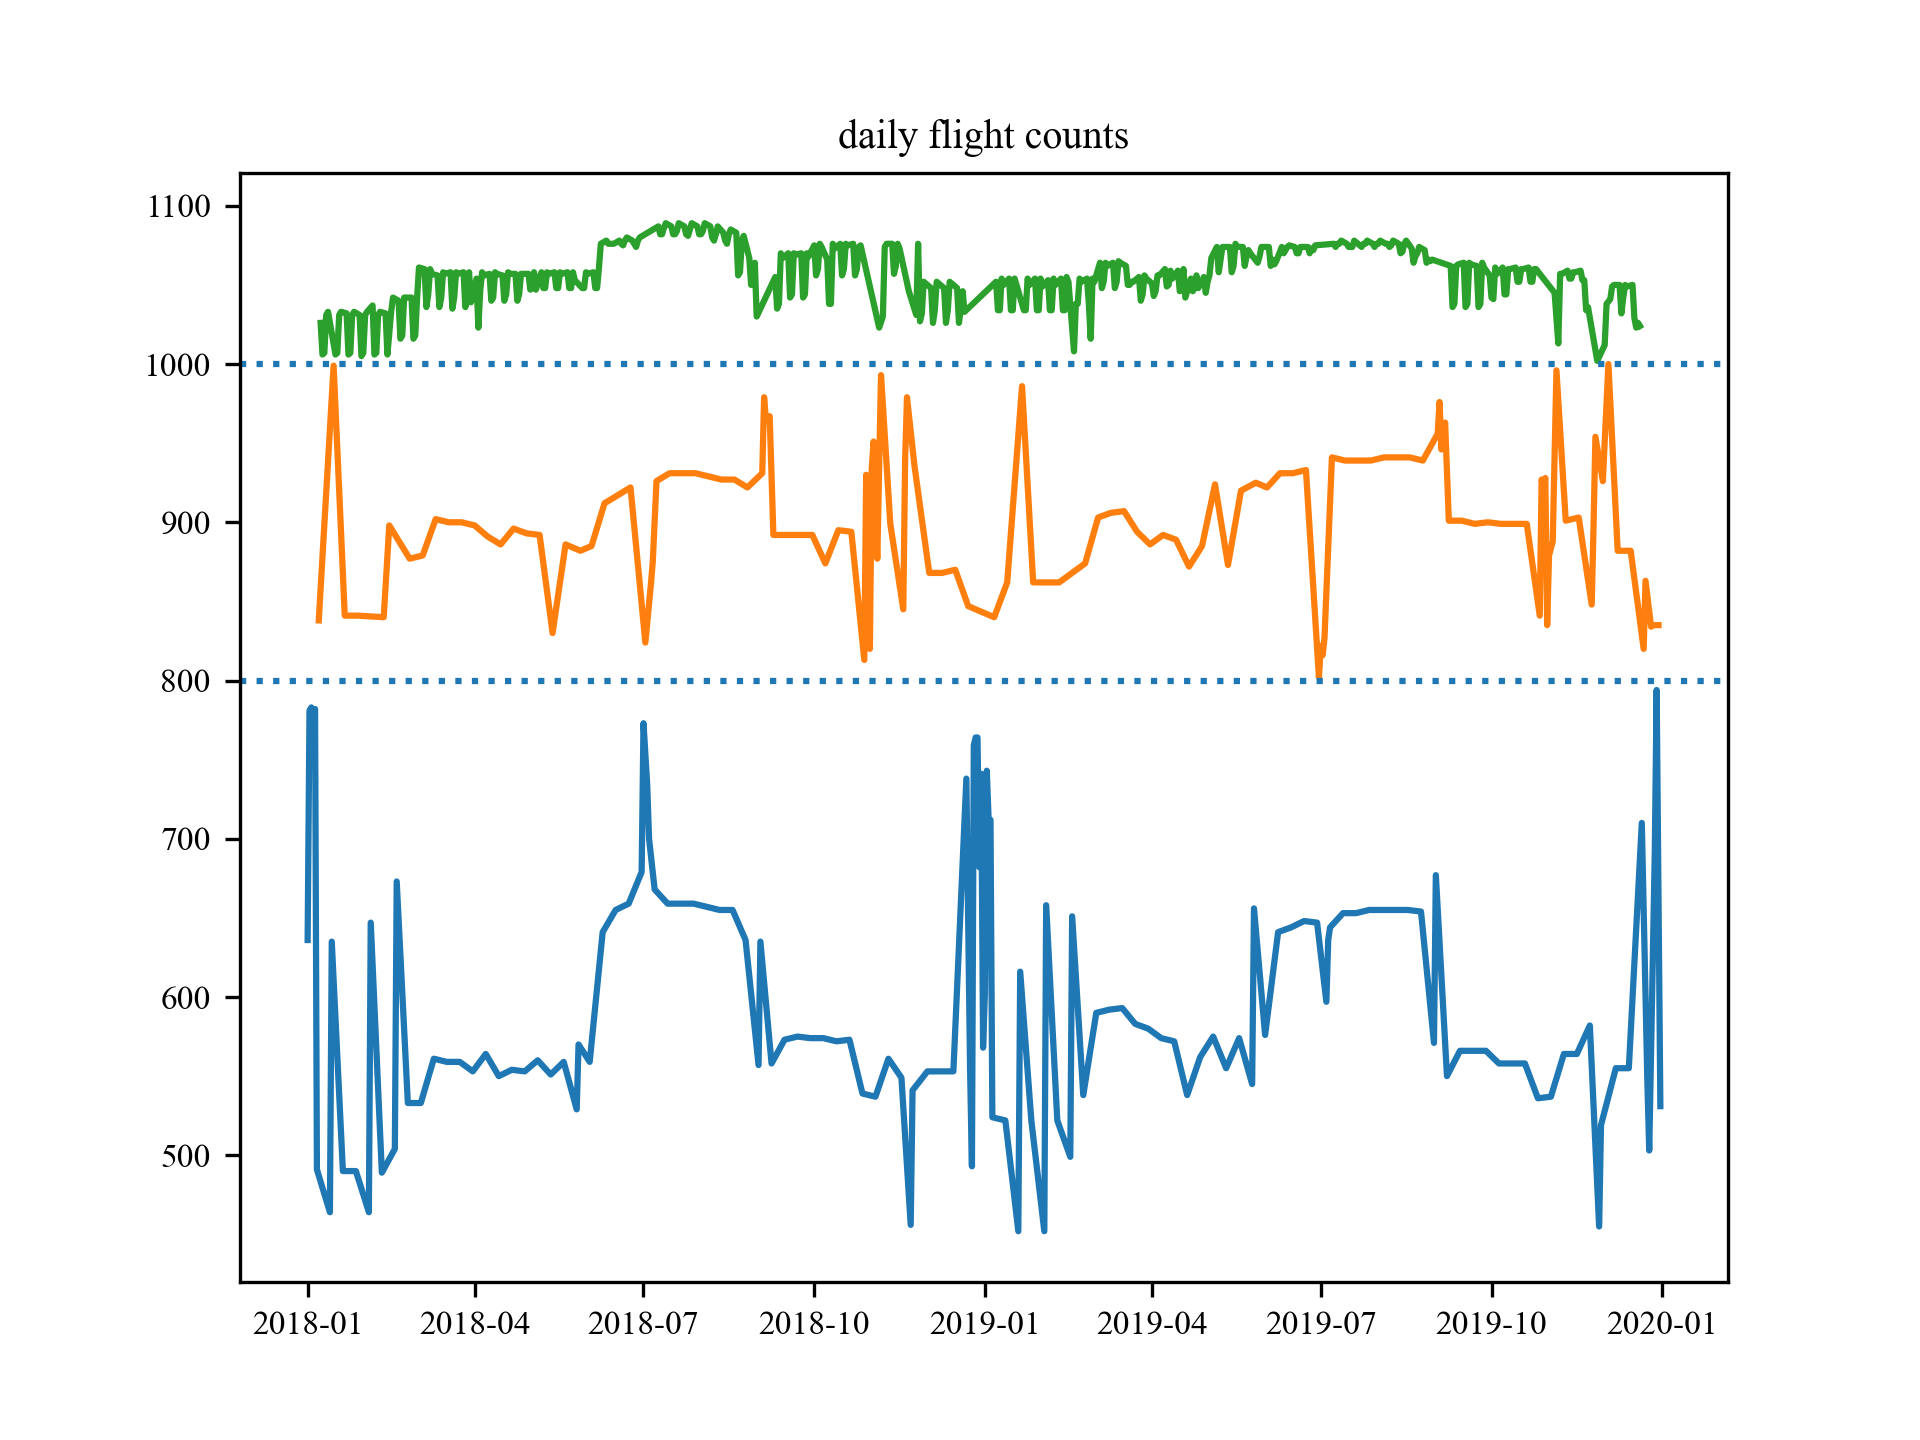

In [130]:
freq = '1D'
start = '2018-01-01'
end = '2020-01-01'

flight_counts = process_series(
    sdf.flight_number,
    ('size', freq),
    ('filter_index', start, end)
)

cutoffs = [0, 800, 1000, 9999]

flight_counts_list = []
names = []
cutoff_lines = []

for i in range(1, len(cutoffs)):
    lo = cutoffs[i-1]
    hi = cutoffs[i]
    fc = flight_counts.loc[
        (flight_counts > lo) & (flight_counts <= hi)
    ]
    flight_counts_list.append(fc)
    names.append(f'days with daily flight count in [{lo}, {hi}), total: {len(fc)}')
    # cutoff_lines.append(hi)
cutoff_lines = cutoffs[1:-1]

zlist = list(zip(flight_counts_list, names))

plt.figure()
for fc, name in zlist:
    plt.plot(fc)
for cl in cutoff_lines:
    plt.axhline(cl, linestyle=':')
plt.title('daily flight counts')
# plt.legend()

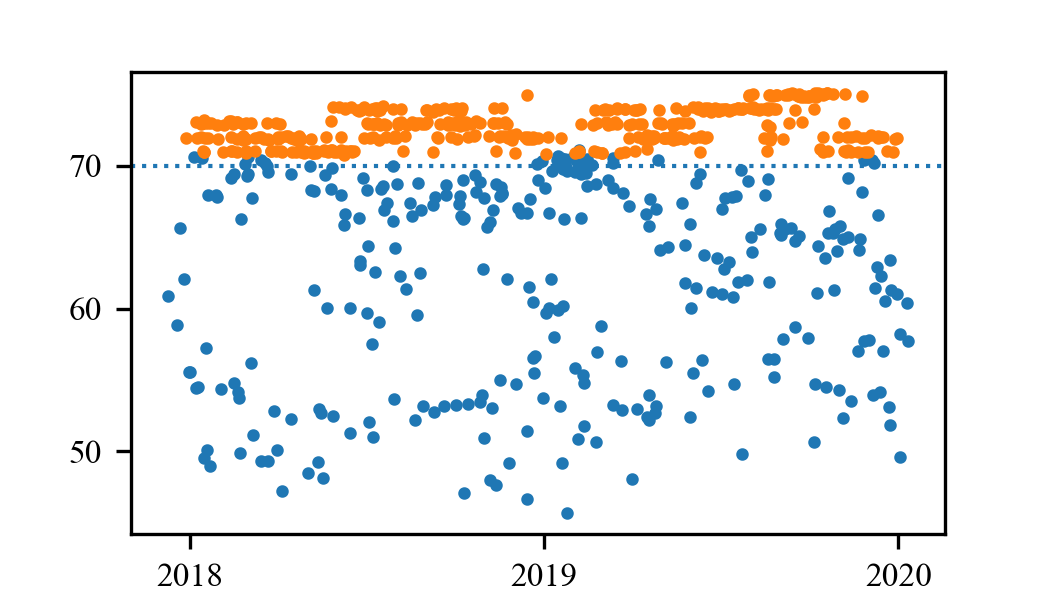

In [165]:
freq = '1D'
start = '2018-01-01'
end = '2020-01-01'

tmp = sdf.scheduled_event_datetime.copy()
tmp.index = pd.DatetimeIndex(sdf.scheduled_event_datetime)
# print(tmp)

l = 1
capacity_counts = process_series(
    tmp,
    ('filter_index', start, end),
    ('size', f'{l}H'),
    ('scale', 1/l),
    ('max', freq),
)

cutoffs = [0, 70, 999]

capacity_counts_list = []
names = []
cutoff_lines = []

def rand_jitter(arr, k=.01):
    stdev = (.01 if k is None else k) * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(ax, x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, hold=None, k=None, **kwargs):
    return ax.scatter(rand_jitter(x, k), rand_jitter(y, k), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, **kwargs)

for i in range(1, len(cutoffs)):
    lo = cutoffs[i-1]
    hi = cutoffs[i]
    fc = capacity_counts.loc[
        (capacity_counts > lo) & (capacity_counts <= hi)
    ]
    capacity_counts_list.append(fc)
    names.append(f'days with peak (avg over {l}H blocks) scheduled capacity in [{lo}, {hi}), total: {len(fc)}')
    # cutoff_lines.append(hi)
cutoff_lines = cutoffs[1:-1]

zlist = list(zip(capacity_counts_list, names))

fig, ax = plt.subplots(figsize=(3.5,2.0))
# print(len(list(zlist)))
for fc, name in zlist:
    # print("hi")
    # print(fc.index, fc, name)
    jitter(ax, fc.index, fc, s=4, c=None, k=.02)
for cl in cutoff_lines:
    plt.axhline(cl, linestyle=':', linewidth=1)
# plt.title(f'daily peak (avg over {l}H blocks) scheduled capacity')

import matplotlib.dates as md

step = 1
ax.xaxis.set_major_locator(md.YearLocator(step, month = 1, day = 1))
ax.xaxis.set_major_formatter(md.DateFormatter('%Y'))

# plt.legend()

In [166]:
def split_scatter_test(lst, zl_idx, figsize):
    idx = lst[zl_idx].index
    fig = scatter_test(
        processed_ceiling[idx], 
        processed_visibility[idx], 
        processed_delay[idx],
        figsize=figsize
    )
    print(names[zl_idx])
    return fig

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


days with peak (avg over 1H blocks) scheduled capacity in [0, 70), total: 311


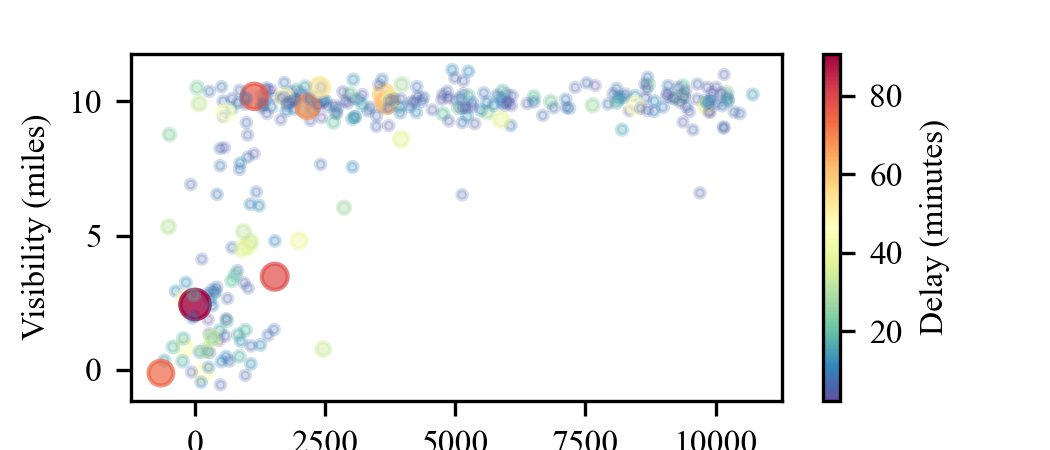

In [171]:
fig = split_scatter_test(capacity_counts_list, 0, (3.5,1.5))
for ext in ('png', 'eps', 'pdf'):
    plt.savefig(f'paper_plots/split_low_bubble2d.{ext}', bbox_inches='tight', pad_inches=0.01)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


days with peak (avg over 1H blocks) scheduled capacity in [70, 999), total: 419


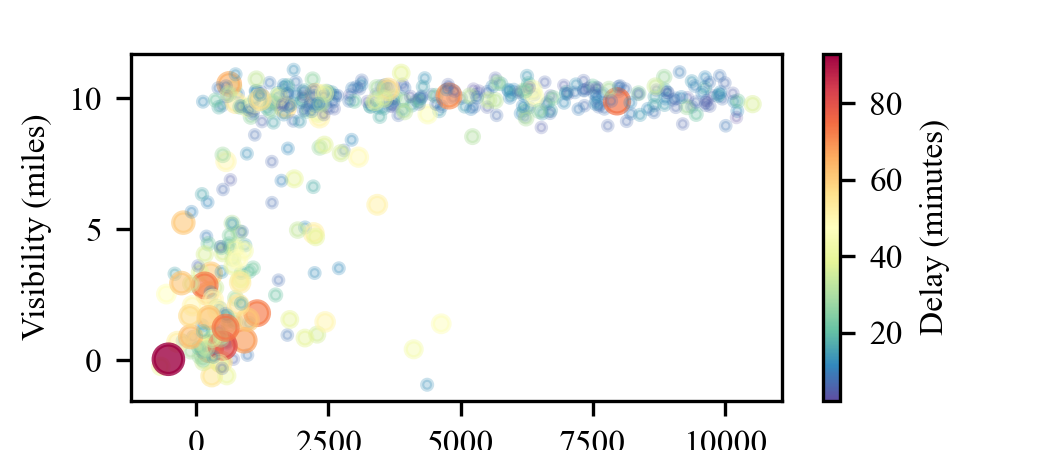

In [172]:
fig = split_scatter_test(capacity_counts_list, 1, figsize=(3.5,1.5))
for ext in ('png', 'eps', 'pdf'):
    plt.savefig(f'paper_plots/split_high_bubble2d.{ext}', bbox_inches='tight', pad_inches=0.01)

In [195]:
def scatter_test_3d(processed_ceiling, processed_visibility, z, z_label, a, k=.04,figsize=(12,12)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection='3d')

    a = a.to_numpy()

    c = a * 60 #* kde(samples).evaluate(samples)
    cmap = plt.colormaps["Spectral_r"]

    norm = colors.Normalize(min(c), max(c))

    def rand_jitter(arr, k=.01):
        stdev = (.01 if k is None else k) * (max(arr) - min(arr))
        return arr + np.random.randn(len(arr)) * stdev

    def jitter(ax, x, y, z, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, hold=None, k=None, **kwargs):
        return ax.scatter(rand_jitter(x, k), rand_jitter(y, k), rand_jitter(z, k), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, **kwargs)

    cn = ((c-min(c))/(max(c)-min(c)))
    cns = 23*(cn**2)+2
    cna = .6*cn+.2
    jitter(ax, processed_ceiling, processed_visibility, z, c=c, cmap=cmap, alpha=cna, s=cns, k=k)

    # ax.set_xlim(-80, 4000)
    # ax.set_ylim(-.1, 5)
    # cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, fraction=0.020, pad=0.04)
    # cbar.set_label('delay (minutes)')

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    # ax.set_xlabel('ceiling (ft)')
    # ax.set_ylabel('visibility (mi)')
    # ax.set_zlabel(z_label)

    # for angle in range(0, 360):
    #     ax.view_init(30, 40)
    ax.view_init()

    return fig


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


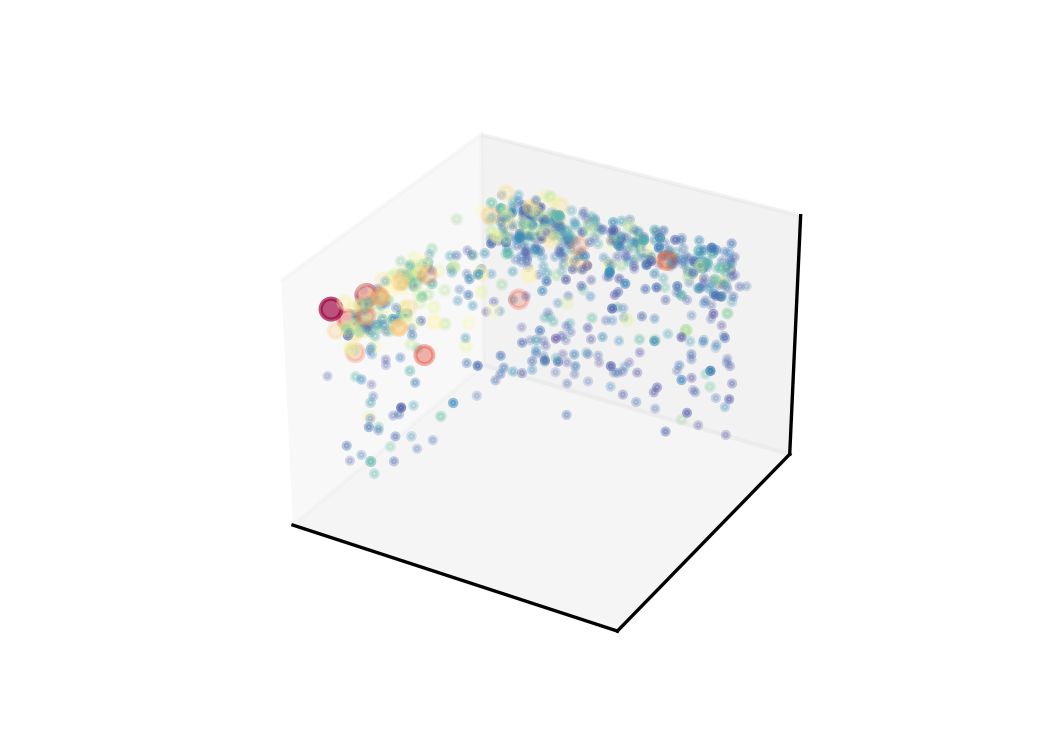

In [196]:
idx = capacity_counts.index

# import matplotlib
# matplotlib.rcParams['axes.labelpad'] = 0

fig = scatter_test_3d(
    processed_ceiling[idx], 
    processed_visibility[idx], 
    capacity_counts, 
    'scheduled capacity (ops/hr)', 
    processed_delay[idx], 
    k=.04,
    figsize=(3.5,2.5)
)


for ext in ('png', 'eps', 'pdf'):
    plt.savefig(f'paper_plots/capacity_bubble3d.{ext}', bbox_inches='tight', pad_inches=0.01)